In [2]:
import numpy as np
import cv2 as cv
import mediapipe as mp
from time import sleep
from functools import cmp_to_key
from commonfunctions import *

In [31]:
# get threshold value

def preProcessImageEnhance(img):
    lab= cv.cvtColor(img, cv.COLOR_RGB2LAB)
    l_channel, a, b = cv.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv.createCLAHE(clipLimit=20.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv.cvtColor(limg, cv.COLOR_LAB2RGB)
    return enhanced_img


def calcThreshold(hist, accHist, iFrom, iTo):
    iFrom, iTo = int(iFrom), int(iTo)
    numOfPixels = accHist[iTo] - (accHist[iFrom - 1] if iFrom > 0 else 0)
    mean = np.sum(
        hist[iFrom:iTo+1] * np.arange(iFrom, iTo+1)
    ) / numOfPixels
    return round(mean)


def avgThreshold(hist, accHist, Tinit):
    mean1 = calcThreshold(hist, accHist, 0, Tinit - 1)
    mean2 = calcThreshold(hist, accHist, Tinit, hist.shape[0] - 1)
    newThreshold = round((mean1 + mean2) / 2)
    return newThreshold if Tinit == newThreshold else avgThreshold(hist, accHist, newThreshold)


def getGlobalThreshold(img):
    img2 = np.copy(img)
    hist = np.histogram(img2, bins=np.arange(256))[0]
    accHist = np.cumsum(hist)
    Tinit = calcThreshold(hist, accHist, 0, hist.shape[0] - 1)
    return avgThreshold(hist, accHist, Tinit)  # get threshold


def get_image_with_skin_color(img):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = (B - Y) * 0.564 + 128
    Cr = (R - Y) * 0.713 + 128
    outImg = (Cb >= 77) * (Cb <= 127) * (Cr >= 133) * (Cr <= 187)
    return outImg


def get_image_with_skin_color_hsv(img):
    lower_hsv = np.array([0, 48, 80], dtype="uint8")
    upper_hsv = np.array([20, 255, 255], dtype="uint8")
    hsv_image = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    skin_region = cv.inRange(hsv_image, lower_hsv, upper_hsv)
    return skin_region


def enhance_image(img,iterations=7):
    se = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]).astype('uint8')
    enhanced_image = np.array(img).astype('uint8')
    enhanced_image = cv.erode(
        enhanced_image, se, iterations=iterations
    )
    enhanced_image = cv.dilate(
        enhanced_image, se, iterations=iterations
    )
    return enhanced_image


def getSingleBoundaries(contour):
    return [
        int(np.min(contour[:, 0])), int(np.max(contour[:, 0])),
        int(np.min(contour[:, 1])), int(np.max(contour[:, 1]))
    ]


def getContoursBoundaries(img):
    contours = find_contours(img,  fully_connected='high')
    return [getSingleBoundaries(contour) for contour in contours]


def getSortedContoursBoundaries(img, compare_function):
    contours = getContoursBoundaries(img)
    return sorted(contours, key=cmp_to_key(compare_function))


def getCompareFunction(preferRightHand):
    if preferRightHand:
        return lambda item1, item2: item2[0] - item1[0]
    return lambda item1, item2: item1[0] - item2[0]


def isThisImageRepresentsHand(img):
    mp_hands = mp.solutions.hands
    hand = mp_hands.Hands()
    result = hand.process(img)
    return result.multi_hand_landmarks


def isContourContainsHand(contour, img):
    [Xmin, Xmax, Ymin, Ymax] = contour
    if Xmax - Xmin >= 50 and Ymax - Ymin >= 50:
        contour_img = img[max(Xmin-70, 0):min(Xmax+70, img.shape[0]),
                          max(Ymin-70, 0):min(Ymax+70, img.shape[1])]
        return isThisImageRepresentsHand(contour_img)


def compareFingers(contour1, contour2):
    return int(np.max(contour1[:, 0])-np.min(contour1[:, 0])) - int(np.max(contour2[:, 0])-np.min(contour2[:, 0]))

def detectFingers(original):
    if original is None:
        return None, None
    image = original > 0.9
    numberOfIteration = (image.shape[0]+image.shape[1])//12
    for i in range(numberOfIteration):
        image = binary_erosion(image)
    for i in range(numberOfIteration):
        image = binary_dilation(image)

    contours = find_contours(image)
    center = ()
    radius = 0

    contours = sorted(contours, key=cmp_to_key(compareFingers))
    if not len(contours) > 0:
        return None, None
    Ymin = int(np.min(contours[-1][:, 1]))
    Ymax = int(np.max(contours[-1][:, 1]))
    Xmin = int(np.min(contours[-1][:, 0]))
    Xmax = int(np.max(contours[-1][:, 0]))
    center = ((Xmin+Xmax)//2, (Ymin+Ymax)//2)
    radius = center[0] - Xmin

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if math.dist((i, j), center) < radius:
                original[i, j] = 0

    for i in range(5):
        original = binary_erosion(original)
    for i in range(5):
        original = binary_dilation(original)
    fingersCotours = find_contours(original)
    return len(fingersCotours)

def detectHand(binaryImg, mainImg, preferRightHand):
    contours = getSortedContoursBoundaries(
        binaryImg, getCompareFunction(preferRightHand)
    )
    for contour in contours:
        if isContourContainsHand(contour, mainImg):
            [Xmin, Xmax, Ymin, Ymax] = contour
            return np.array(binaryImg[Xmin:Xmax, Ymin:Ymax]), (Xmin, Xmax, Ymin, Ymax)
    return None, (0, 0)


(None, None)


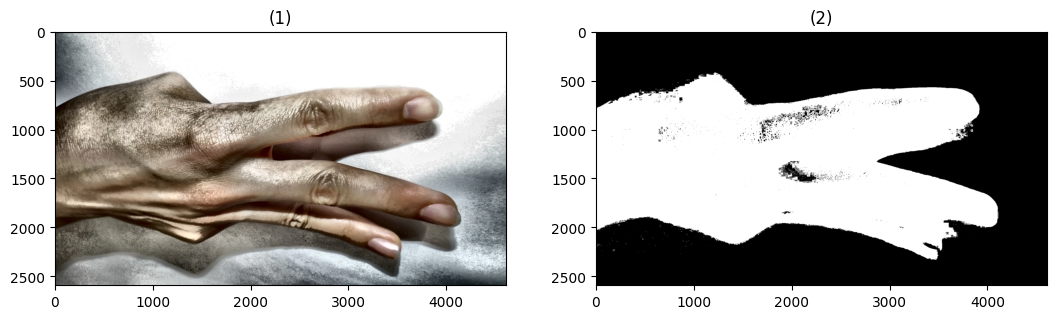

In [32]:
image = io.imread('../data/men/3/3_men (2).JPG')
image = preProcessImageEnhance(image)
binary_image = get_image_with_skin_color(image)
binary_image = enhance_image(binary_image,iterations=0)
hand_image, hand_margin = detectHand(binary_image, image,True)
print(detectFingers(hand_image))
show_images([image, binary_image])


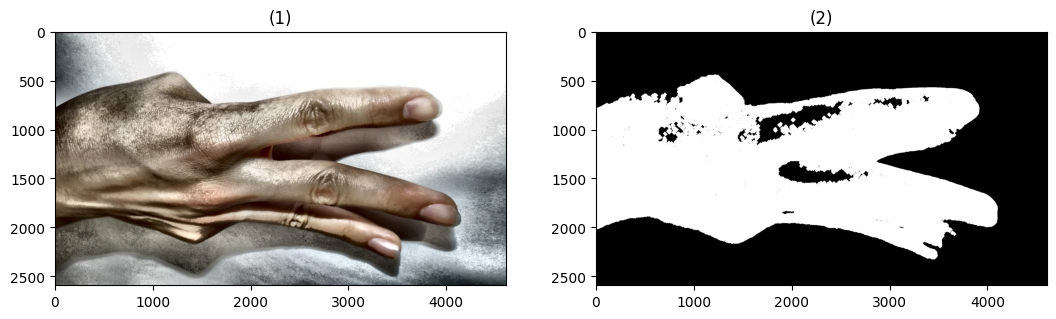